In [1]:
import pandas as pd
import numpy as np 
import sklearn as sk 
from hmmlearn import hmm
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.ndimage.interpolation import shift
from datetime import date, timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns


### Signal Generation Functions

In [2]:
def generate_signal_rolling(start, end, X, states, window, delay, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[start-window:start])
    predictions = model.predict(X[start-window:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[start-window+i:start+i])
        predictions = model.predict(X[start-window+i:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= delay:
            signal.append(pred)
            
        elif count < delay:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

def generate_signal_expanding(start, end, X, states, delay, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[:start])
    predictions = model.predict(X[:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[:start+i])
        predictions = model.predict(X[:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= delay:
            signal.append(pred)
            
        elif count < delay:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

### Cash Back-test Function

In [3]:
def backtest_signal(price, signal):
    w = np.zeros(np.shape(price))
    cash = np.zeros(np.shape(price))
    cash[0] = 10000

    for i in range(0, len(price)):

        if i == len(price)-1:
            break

        if signal[i] == 1: 
            w[i+1] = cash[i]/price[i+1]  + w[i]
            cash[i+1] = 0

        elif signal[i] == 0:
            cash[i+1] = w[i]*price[i+1] + cash[i]
            w[i+1] = 0
            
    strat = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]
    
    return strat

### Performance Ratios Functions

In [14]:
def log_returns(strat):
    returns = np.log(shift(strat, -1)/strat)
    returns = np.delete(returns, -1)
    return returns

def sharpe(returns):
    sharpe_ratio = np.mean(returns)/np.std(returns)
    return np.round(sharpe_ratio * np.sqrt(252), 3)

def sortino(returns):
    downside_returns = [ret for ret in returns if ret < 0]
    std = np.std(downside_returns)
    sortino = np.mean(returns)/std
    return np.round(sortino * np.sqrt(252), 3)

def max_dd(data):
    p = np.argmax(np.maximum.accumulate(data) - data)
    q = np.argmax(data[:p])
    max_drawdown = (data[p]-data[q])/data[q]
    return np.round(abs(max_drawdown), 3)

def calmar(returns, strat):
    drawdown = max_dd(strat)
    calmar = np.sqrt(252) * np.mean(returns)/drawdown
    return np.round(calmar, 3) 

def absolute_return(price):
    abs_ret = (price[-1] - price[0])/price[0]
    annual_abs_ret = abs_ret/(len(price)/252)
    return annual_abs_ret

def print_ann_ret(strat, price):
    print("Strategy Annualised Return:", round(absolute_return(strat),3), sep='\n')
    print("Asset Annualised Return:", round(absolute_return(price.values),3), sep='\n')

def print_ratios(strategy, price):
    print("Strategy:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(strat)),
    sortino(log_returns(strat)),
    calmar(log_returns(strat), strat))
    print("Asset:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(price.values)),
    sortino(log_returns(price.values)),
    calmar(log_returns(price.values), price.values))
    print("\n")
    
def plot_highlighted_graph(price, threshold, string):
    values, ids = dc(price, threshold)

    d = []

    for i in range(1, len(idx)-1):
        if signal[i] == signal[i+1]:
            pass
        else:
            d.append(idx[i])

    d.append(idx[-1])

    plt.figure(figsize=(12,4))
    plt.title("Long (green) and Short (red) Regions of Price Output by HMM Model: Rolling Window", fontsize=18)
    plt.ylabel("Price", fontsize=18)
    plt.xlabel("Date", fontsize=18)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.plot(idx[1:], price)
    plt.xticks(rotation=45)
    plt.scatter(idx[ids], values, s=200, c='r')

    if signal[0] == 1:
        plt.axvspan(idx[0], d[0], facecolor='g', alpha=0.5)  
        for i in range(0, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='r', alpha=0.5)
        for i in range(1, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='g', alpha=0.5)
    plt.tight_layout()
    #plt.grid()
    plt.savefig(string)
    plt.show() 

### DC Points Functions

In [5]:
def dc(price, threshold):

    curr_min = price[0]
    curr_min_id = 0
    curr_max = price[0]
    curr_max_id = 0
    min_bool = False
    max_bool = False

    values = []
    ids = []

    for i in range(1, len(price)):


        if price[i] > curr_max:
            curr_max = price[i]
            curr_max_id = i


        elif price[i] < curr_min:
            curr_min = price[i]
            curr_min_id = i


        if abs((price[i] - curr_min)/curr_min) >= threshold and min_bool == False:
            # save values and now look for OS point
            values.append(curr_min)
            ids.append(curr_min_id)

            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            min_bool = True
            max_bool = False

        elif abs((price[i] - curr_max)/curr_max) >= threshold and max_bool == False:
            # save values and now look for OS point
            values.append(curr_max)
            ids.append(curr_max_id)
            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            max_bool = True
            min_bool = False


    if min_bool == True:
        values.append(curr_max)
        ids.append(curr_max_id)
        
    elif max_bool == True:
        values.append(curr_min)
        ids.append(curr_min_id)
    

    return values, ids

## Results for Rolling Window Back-Test
- 2 states
- 4 year rolling window
- 7 day delay

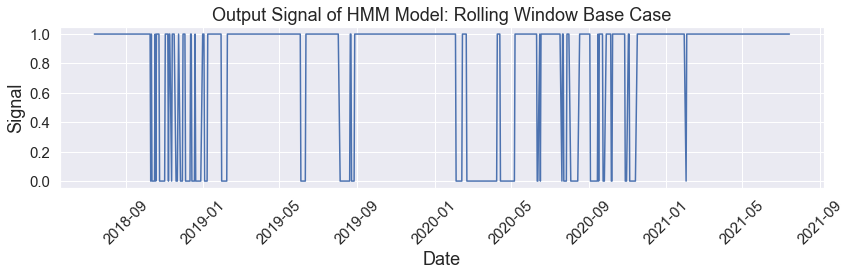

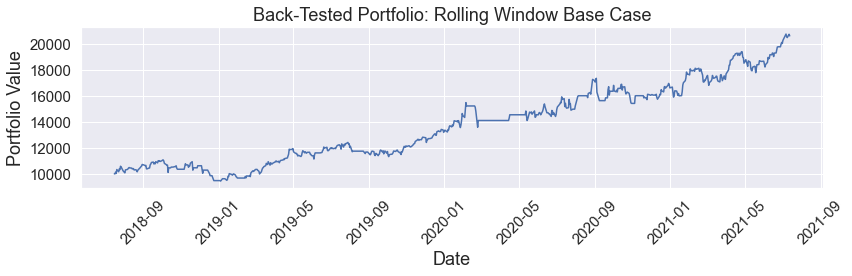

Strategy:
Sharpe | Sortino | Calmar Ratios
1.156 1.309 0.137
Asset:
Sharpe | Sortino | Calmar Ratios
1.223 1.611 0.077


Strategy Annualised Return:
0.356
Asset Annualised Return:
0.595


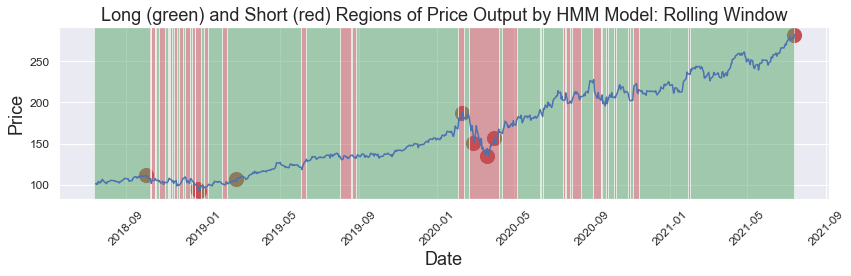

In [15]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change().dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
window = 1008
delay = 1
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_rolling(start, end, X, states, window, delay, 22)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Rolling Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Rolling Window signal base result")
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Rolling Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Rolling Window portfolio backtest base result")
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, "Rolling window base result performance")

## Results for Expanding Window Back-Test (same Paramters)

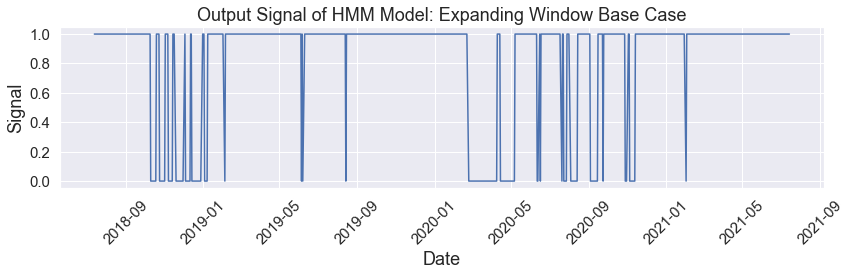

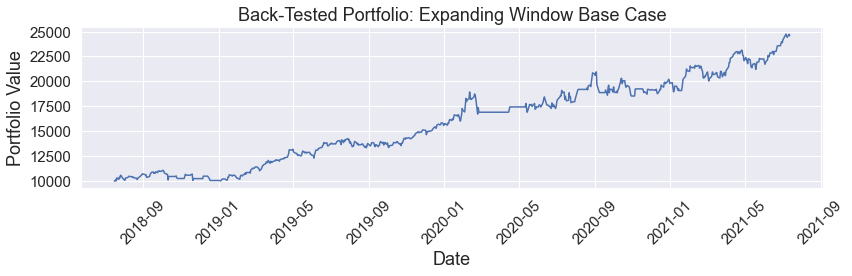

Strategy:
Sharpe | Sortino | Calmar Ratios
1.413 1.706 0.163
Asset:
Sharpe | Sortino | Calmar Ratios
1.223 1.611 0.077


Strategy Annualised Return:
0.487
Asset Annualised Return:
0.595


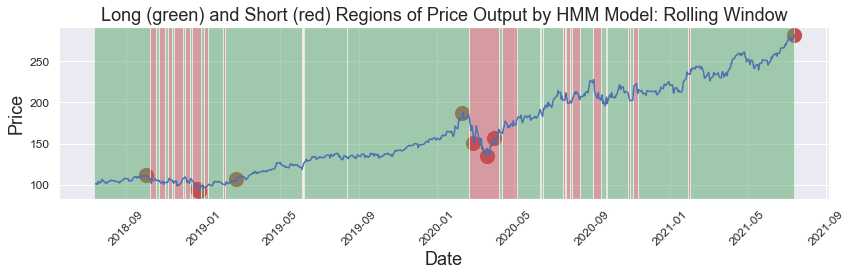

In [16]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 1
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_expanding(start, end, X, states, delay, 2200)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Expanding Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Expanding Window signal base result")
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Expanding Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Expanding Window portfolio backtest base result")
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, "expanding window base result performance")